<a href="https://colab.research.google.com/github/xsuryanshx/Caption-and-Attributes-Prediction/blob/main/TM_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Name - Suryansh Singh Rawat
* Email - suryanshsinghrawat@gmail.com
* Phone - +917722035623

**Note**
* We need to design two models where the first one will take any fashion image URL and generate an AI based description.
* We are free to take your assumptions and solve the problem.
* We are assuming that the input images in the model will be downloaded already.
* The model gives a decent overall accuracy (~97%) and the performance on unseen images is also decent. 

Requirements

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import string
import pickle
import cv2
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras.applications import ResNet50, imagenet_utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, BatchNormalization, Input, \
                                    LSTM, Embedding, Input, TimeDistributed, Bidirectional, Activation, RepeatVector, Concatenate

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/TM Assignment

/content/drive/MyDrive/TM Assignment


In [4]:
df = pd.read_excel('dataset 1.xlsx')
df.head()

,Title,Description,Material,Pattern,Neckline,Image_Path
0,Peach Poly Crepe jumpsuit,This stylish foil print kurta from janasya is ...,Crepe,Printed,Round Neck,/images/pic_0.jpg
1,Light Brown Bias Yoke Checks Top,This check pattern top by Work Label is crafte...,Cotton,Checks,Round Neck,/images/pic_1.jpg
2,Off White Geometric Straight Cotton Dobby Top ...,"Featuring elegant printed details, this off wh...",Viscose,Checks,Round Neck,/images/pic_2.jpg
3,Blue Me Away Cape Top,Add an extra dose of style to your casual ward...,Polyester,Solid/Plain,V-Neck,/images/pic_3.jpg
4,Yellow On A High Gown,Yellow polyester georgette maxi dress. Polyest...,Polyester,Solid/Plain,V-Neck,/images/pic_4.jpg


In [5]:
#Adding a '.' before the image path to access it
df['Image_Path'] = '.'+df['Image_Path']
imgpath = df['Image_Path']
description = df['Description']

In [6]:
df.head()

,Title,Description,Material,Pattern,Neckline,Image_Path
0,Peach Poly Crepe jumpsuit,This stylish foil print kurta from janasya is ...,Crepe,Printed,Round Neck,./images/pic_0.jpg
1,Light Brown Bias Yoke Checks Top,This check pattern top by Work Label is crafte...,Cotton,Checks,Round Neck,./images/pic_1.jpg
2,Off White Geometric Straight Cotton Dobby Top ...,"Featuring elegant printed details, this off wh...",Viscose,Checks,Round Neck,./images/pic_2.jpg
3,Blue Me Away Cape Top,Add an extra dose of style to your casual ward...,Polyester,Solid/Plain,V-Neck,./images/pic_3.jpg
4,Yellow On A High Gown,Yellow polyester georgette maxi dress. Polyest...,Polyester,Solid/Plain,V-Neck,./images/pic_4.jpg


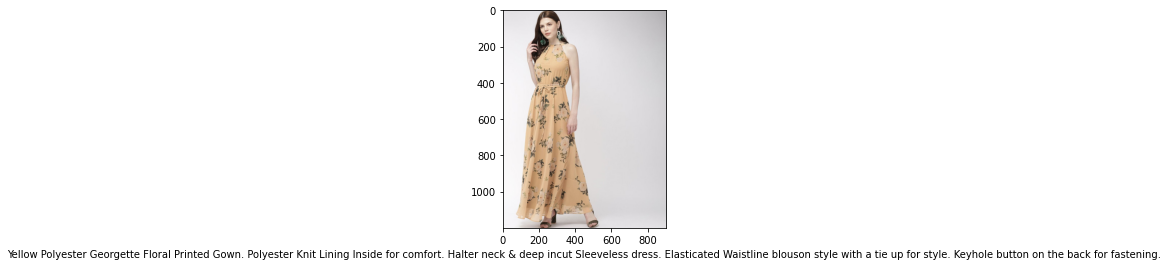

In [76]:
k = 30 #random number from 0-499
img = cv2.imread(imgpath[k])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.xlabel(description[k]);

Image Feature extraction using ResNet50 Model

In [77]:
#Downloadign ResNet50 Model
ResNet = ResNet50(include_top=True)

In [78]:
#Model layout
ResNet_model = ResNet50(weights='imagenet')
ResNet_model = Model(inputs=ResNet_model.inputs, outputs=ResNet_model.layers[-2].output)
ResNet_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [79]:
#Creating a dictionary of image path and predicted image feaure using ResNet50 Model
imgfeatures = {}
count = 0
for i in range(len(imgpath)):
  img = cv2.imread(imgpath[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(224,224))
  img = img.reshape(1,224,224,3)
  imgfeatures[imgpath[i]] = ResNet_model.predict(img)[0]
  count+=1
  if count%50 == 0:
    print(count,'image features predicted')

50 image features predicted
100 image features predicted
150 image features predicted
200 image features predicted
250 image features predicted
300 image features predicted
350 image features predicted
400 image features predicted
450 image features predicted
500 image features predicted


In [80]:
#storing the image features
with open('imgfeatures.txt','wb') as f1:
  pickle.dump(imgfeatures,f1)

In [81]:
#loading the stored image feature dictionary
imgfeatures = pickle.load(open('imgfeatures.txt','rb'))

In [82]:
#Creating  dictionary of image path and image description
catalouge = {}
for i in range(len(imgpath)):
  catalouge[imgpath[i]] = str('seqstart ')+description[i]+str(' seqend')

NLP Model

In [116]:
#Model Tokenizer for descriptions
tokenizer = Tokenizer() #split=" ",filters='!"#$%()*+,-.:;<=>?@[\\]^_`{|}~\t\n'
data = []
for i in range(len(description)):
  data.append(catalouge[imgpath[i]].lower())

tokenizer.fit_on_texts(data)

total_words = int(len(tokenizer.word_index))+1
print(total_words)
print(tokenizer.word_index)
print(tokenizer.word_counts)

1526
{'and': 1, 'a': 2, 'with': 3, 'this': 4, 'seqstart': 5, 'seqend': 6, 'the': 7, 'to': 8, 'for': 9, 'style': 10, 'dress': 11, 'top': 12, 'is': 13, 'in': 14, 'look': 15, 'sleeves': 16, 'of': 17, 'pair': 18, 'it': 19, 'heels': 20, 'from': 21, 'neck': 22, 'complete': 23, 'on': 24, 'at': 25, 'features': 26, 'crafted': 27, 'fit': 28, 'your': 29, 'neckline': 30, 'polyester': 31, 'by': 32, 'front': 33, 'back': 34, 'up': 35, 'cotton': 36, 'jumpsuit': 37, 'high': 38, 'black': 39, 'v': 40, 'statement': 41, 'an': 42, 'printed': 43, 'regular': 44, 'waist': 45, 'shoulder': 46, 'shirt': 47, 'blue': 48, 'zipper': 49, 'floral': 50, 'silhouette': 51, 'fastening': 52, 'tie': 53, 'ease': 54, 'wear': 55, 'casual': 56, 'accessories': 57, 'will': 58, 'long': 59, 'you': 60, 'short': 61, 'buy': 62, 'online': 63, 'white': 64, 'or': 65, 'perfect': 66, 'button': 67, 'crepe': 68, 'round': 69, 'side': 70, 'that': 71, 'knit': 72, 'has': 73, 'concealed': 74, 'detailing': 75, 'comfort': 76, 'fabric': 77, 'jeans': 

In [117]:
#creating input sequence for predicting description
input_sequence = []
image_input = []
for j in range(len(data)):
  token_list = tokenizer.texts_to_sequences([data[j]])[0]
  for i in range(1,len(token_list)):
    n_grams = token_list[:i]
    input_sequence.append(n_grams)
    image_input.append(imgfeatures[imgpath[j]])
print(len(input_sequence))
max_len = max([len(x) for x in input_sequence])
print(max_len)

input_sequence = pad_sequences(input_sequence, maxlen=max_len, padding="pre", truncating="pre")

18853
111


In [118]:
#input and output for predicting description
x1, labels = input_sequence[:,:-1] , input_sequence[:,-1]
x2 = tf.keras.utils.to_categorical(labels, num_classes=total_words)

image_input = np.array(image_input)
x1 = np.array(x1)
x2 = np.array(x2)
image_input.shape,x1.shape,x2.shape

((18853, 2048), (18853, 110), (18853, 1526))

Combined Model Training

In [207]:
# Model Layout
embedding_size = 100
img_model = Sequential()
img_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
img_model.add(RepeatVector(max_len-1))
img_model.summary()

nlp_model = Sequential()
nlp_model.add(Embedding(input_dim=total_words, output_dim= embedding_size, input_length=max_len-1))
nlp_model.add(tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True)))
nlp_model.add(Dense(128))
nlp_model.add(Dropout(0.5))
nlp_model.add(TimeDistributed(Dense(embedding_size)))
nlp_model.summary()

concatenate = Concatenate()([img_model.output, nlp_model.output])
x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True))(concatenate)
x = tf.keras.layers.Bidirectional(LSTM(256, return_sequences=False))(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
x = Dense(total_words)(x)
out = Activation('softmax')(x)
model = Model(inputs=[img_model.input, nlp_model.input], outputs = out)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 100)               204900    
_________________________________________________________________
repeat_vector_16 (RepeatVect (None, 110, 100)          0         
Total params: 204,900
Trainable params: 204,900
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 110, 100)          152600    
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 110, 512)          731136    
_________________________________________________________________
dense_53 (Dense)             (None, 110, 128)          65664     
________________________

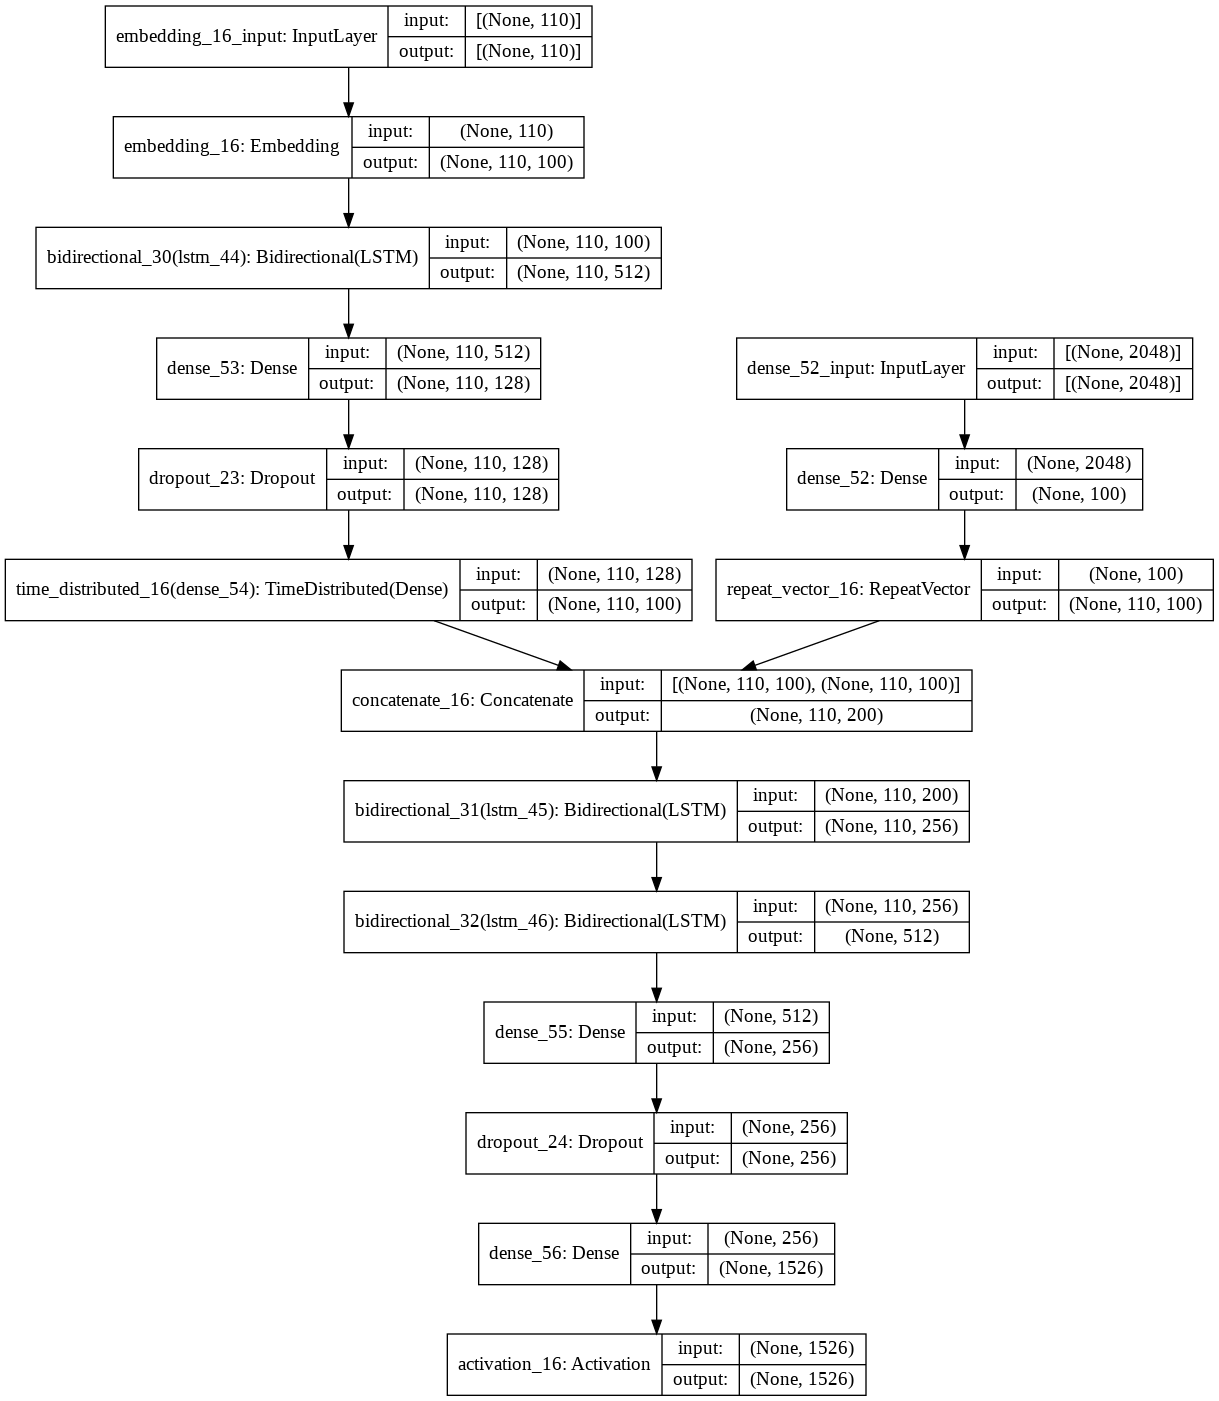

In [208]:
#Model visualisation
plot_model(model, show_shapes=True)

In [ ]:
# trained the model
history = model.fit([image_input, x1], x2, batch_size=64, epochs=80) 

Epoch 1/80
295/295 [==============================] - 27s 65ms/step - loss: 6.0305 - accuracy: 0.0414
Epoch 2/80
295/295 [==============================] - 19s 65ms/step - loss: 5.6220 - accuracy: 0.0462
Epoch 3/80
 34/295 [==>...........................] - ETA: 17s - loss: 5.2823 - accuracy: 0.1002

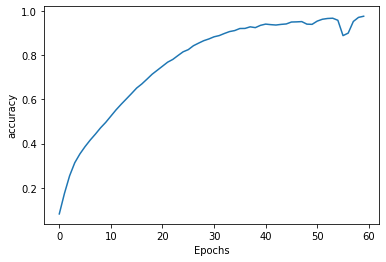

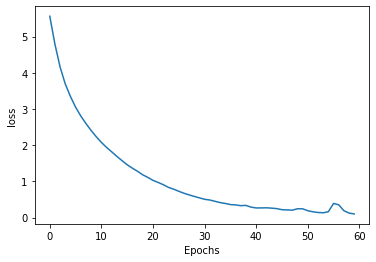

In [179]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [180]:
#saving the trained model
model.save('tm_assignment1 model 1.h5')

In [189]:
#loading the saved model
model = tf.keras.models.load_model('tm_assignment1 model 1.h5')

Trying this model on unseen images

In [190]:
def predict_description(path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img1 = cv2.resize(img,(224,224))
  img2 = img1.reshape(1,224,224,3)
  img_inp = np.array(ResNet_model.predict(img2)[0]).reshape(1,2048)

  seed_text = ["seqstart"]
  while (seed_text[-1]) != 'seqend':
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_len-1, padding='pre')
    predicted = np.argmax(model.predict([img_inp, token_list], verbose=0))
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    seed_text.append(output_word)
    if len(seed_text)>26:
      break
  seed_text = ' '.join(seed_text[1:-1])
  plt.imshow(img)
  plt.xlabel(seed_text);

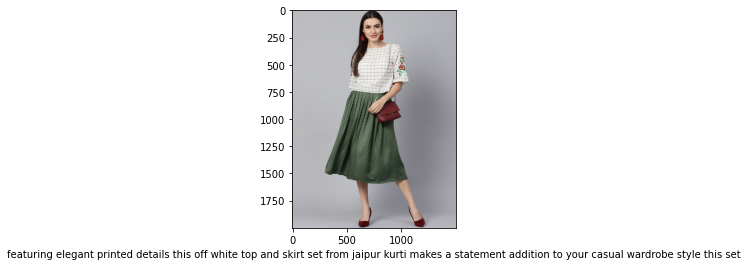

In [191]:
predict_description(path = imgpath[2])

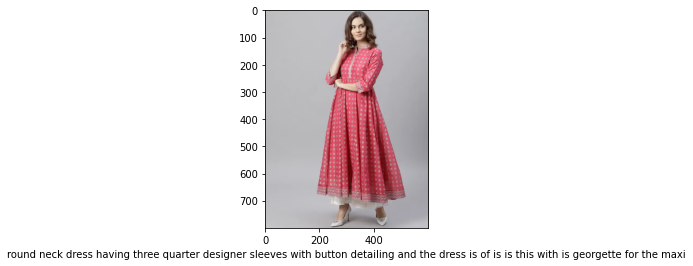

In [192]:
predict_description(path = './imgnew1.jpg')

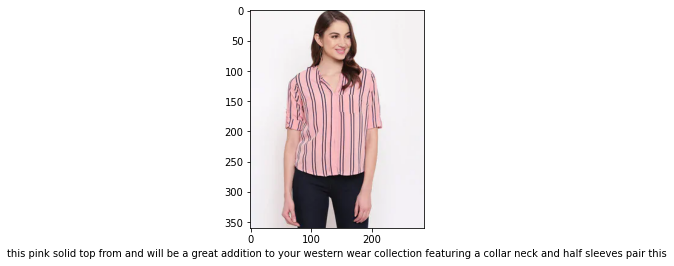

In [193]:
predict_description(path = './imgnew2.jpg')

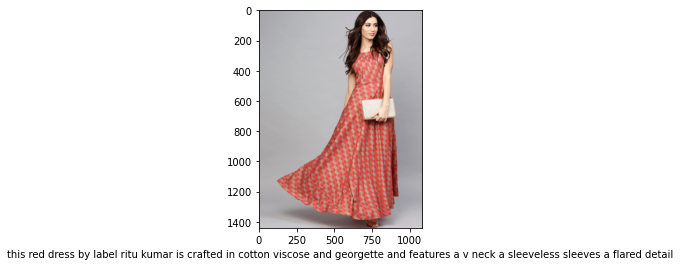

In [194]:
predict_description(path = './imgnew4.jpg')

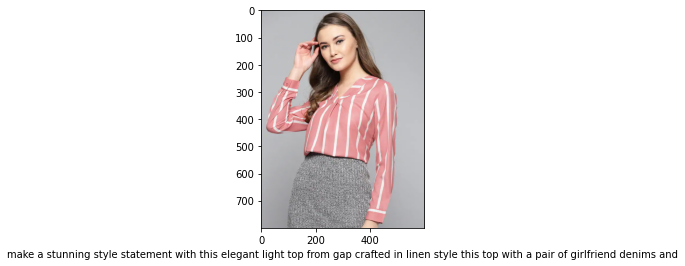

In [195]:
predict_description(path = './imgnew5.jpg')

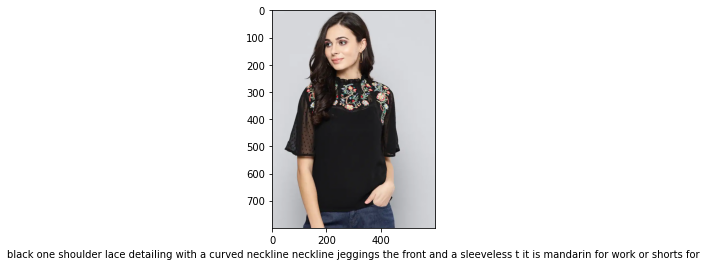

In [200]:
predict_description(path = './imgnew9.jpg')

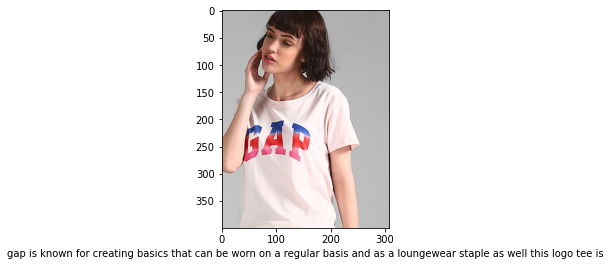

In [205]:
predict_description(path = './imgnew11.jpg')

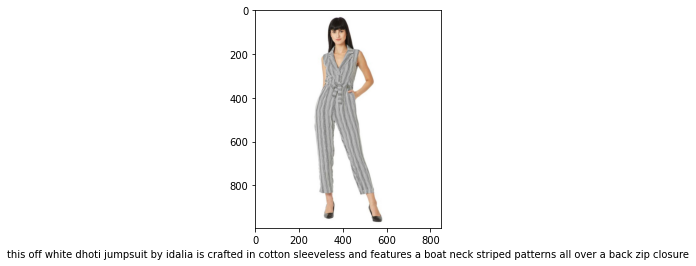

In [206]:
predict_description(path = './imgnew13.jpg')